# import

In [1]:
import os

# Change path for loading config and data
os.chdir('...')
from itertools import chain, product
from pathlib import Path
from typing import Optional, List, Tuple, Union, Any, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import shap
import xgboost
import hdbscan
import umap
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

from src.data_processing.data_loader import DataLoader
from src.molecular_descriptors.descriptors.morfeus_descriptor import MorfeusDescriptor
from src.utils.config import get_config
from src.utils.functool import get_mol_indices
from src.utils.molecule_operator import merge_intermediates, merge_products

%matplotlib inline
plt.style.use('seaborn-v0_8-paper')
plt.rc('font', weight='bold')

In [2]:
config = get_config()
loader = DataLoader(config)
loader.load_data()
loader._raw_data['label_ee'] = abs(loader._raw_data['label_ee'])

# Remove duplicates
loader._raw_data = loader._raw_data.loc[
        sorted(loader._raw_data.groupby(['com_1', 'com_2', 'com_cat'])['label_ee'].idxmax())
].reset_index(drop=True)

metadata = loader.get_metadata()

# Extract and validate species data and descriptors
species_cols, species_smiles, species_calculators = loader.get_species_data()

# Get reaction conditions
condition_data = loader.get_condition_data()

# Get labels
label_data = loader.get_label_data()

# morfeus (N=5) descriptors

In [3]:
mol_registry = pd.read_csv('data/calculators/mol_list.csv')
inter_des_dataset = pd.read_csv('data/calculators/descriptors/morfeus/raw_data_inter_chg1_xtb_intermediate.csv')
product_des_dataset = pd.read_csv('data/calculators/descriptors/morfeus/raw_data_product_s_xtb_product_s.csv')


N_CONFORMERS = 5
step = N_CONFORMERS * N_CONFORMERS

descriptor_start_idx = metadata.shape[1] + 1
inter_des_cols = 'IM_' + inter_des_dataset.columns[descriptor_start_idx:]
product_des_cols = 'Product_' + product_des_dataset.columns[descriptor_start_idx:]
ddg_col = ['ddg']

processed_data = []
transfer_dataset = []
transfer_metadata = []

for idx, row in loader.data.iterrows():
    # Skip Se compounds
    # if 'Se' in row['com_2'] or 'Se' in row['com_cat']:
    #     continue

    # Get intermediate index and descriptors
    com_inter = merge_intermediates(row['com_2'], row['com_cat'])
    inter_idx = get_mol_indices(com_inter, mol_registry)[1][0]

    com_product = merge_products(row['product_base'], row['com_2'])
    product_idx = get_mol_indices(com_product, mol_registry)[1][0]

    ddg = [(8.314 * (row['con_temperature1'] + 273.15) * 
            np.log((1 + abs(row['label_ee']) / 100) / 
                   (1 - abs(row['label_ee']) / 100))) / 4184]

    intermediate_conformer_data = inter_des_dataset[
        inter_des_dataset['index'] == inter_idx
    ][:N_CONFORMERS].values[:, descriptor_start_idx:]
    
    product_conformer_data = product_des_dataset[
        product_des_dataset['index'] == product_idx
    ][:N_CONFORMERS].values[:, descriptor_start_idx:]
    
    row_data = [
        ([idx, row['ID'], row['type']], list(chain(inter_des, product_des, ddg)))
        for inter_des in intermediate_conformer_data
        for product_des in product_conformer_data
    ]
    # if len(row_data) < step:
    #     continue

    processed_data.extend(row_data)

for meta_info, feature_data  in processed_data:
    transfer_metadata.append(meta_info)
    transfer_dataset.append(feature_data)

In [4]:
dataset_morfeus_aug = pd.DataFrame(transfer_dataset, columns=[i for i in chain(inter_des_cols, product_des_cols, ddg_col)])
scaler = StandardScaler()
dataset_morfeus_aug.iloc[:,:-1] = scaler.fit_transform(dataset_morfeus_aug.iloc[:,:-1])

dataset_morfeus_aug

,IM_area,IM_volume,IM_P_bv,IM_S_cat_bv,IM_S_S_bv,IM_S_cat_darea,IM_S_cat_pint,IM_S_S_darea,IM_S_S_pint,IM_S_cat_P,...,Product_S_sarea,Product_S_svol,Product_S_toC1_Lvalue,Product_S_toC1_B1value,Product_S_toC1_B5value,Product_S_toC2_Lvalue,Product_S_toC2_B1value,Product_S_toC2_B5value,Product_S_charge,ddg
0,-0.849574,-0.993797,-0.489013,-1.074946,-0.550260,0.653726,-1.610869,0.564740,-1.456030,0.630811,...,-0.503535,-0.544494,-1.181903,-0.891646,2.011514,2.390614,-0.042761,-1.394232,1.378121,0.008685
1,-0.849574,-0.993797,-0.489013,-1.074946,-0.550260,0.653726,-1.610869,0.564740,-1.456030,0.630811,...,-0.038729,0.281719,-1.181465,-1.160461,2.144368,2.262191,1.169722,-1.478206,0.829361,0.008685
2,-0.849574,-0.993797,-0.489013,-1.074946,-0.550260,0.653726,-1.610869,0.564740,-1.456030,0.630811,...,-0.338523,-0.448948,-1.181917,-0.703540,1.904818,2.319234,0.267854,-1.373626,1.303316,0.008685
3,-0.849574,-0.993797,-0.489013,-1.074946,-0.550260,0.653726,-1.610869,0.564740,-1.456030,0.630811,...,-0.164693,-0.314982,-1.181389,-0.949775,0.893044,0.653944,1.201160,-1.020340,1.308516,0.008685
4,-0.849574,-0.993797,-0.489013,-1.074946,-0.550260,0.653726,-1.610869,0.564740,-1.456030,0.630811,...,-0.492198,-0.436192,-1.174987,0.505060,1.661076,2.136068,0.450001,-1.272001,1.884051,0.008685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5345,-0.495277,-0.496208,0.342040,1.713810,-0.086049,-1.515814,1.513984,0.611059,0.687562,-0.932023,...,0.221981,0.078844,0.332576,-1.262709,-1.405737,-0.781999,-1.361039,0.148777,2.458981,1.002258
5346,-0.495277,-0.496208,0.342040,1.713810,-0.086049,-1.515814,1.513984,0.611059,0.687562,-0.932023,...,0.249692,-0.088365,-1.503638,1.219126,-1.272189,-0.778188,-0.884436,-1.506353,0.880393,1.002258
5347,-0.495277,-0.496208,0.342040,1.713810,-0.086049,-1.515814,1.513984,0.611059,0.687562,-0.932023,...,1.320367,1.264252,0.347038,-0.621508,-1.337126,-0.783456,-1.248220,0.133884,0.466320,1.002258
5348,-0.495277,-0.496208,0.342040,1.713810,-0.086049,-1.515814,1.513984,0.611059,0.687562,-0.932023,...,0.704414,0.333785,-1.375489,1.418945,-1.094496,-0.776715,-1.216768,-1.444603,0.630297,1.002258


In [5]:
transfer_metadata = pd.DataFrame(transfer_metadata, columns=['idx', 'ID', 'stage'])
transfer_metadata

,idx,ID,stage
0,0,6,1
1,0,6,1
2,0,6,1
3,0,6,1
4,0,6,1
...,...,...,...
5345,213,8,1
5346,213,8,1
5347,213,8,1
5348,213,8,1


# def train and draw

In [6]:
def train_conformers(
    reg: Any,
    dataset: Optional[pd.DataFrame] = None,
    transfer_metadata: Optional[pd.DataFrame] = None,
    test_type_id: Optional[List[int]] = None,
    n_conformers: int = 4,
    test_size: float = 0.2,
    random_state: int = 42,
    X_train: Optional[np.ndarray] = None,
    X_test: Optional[np.ndarray] = None,
    y_train: Optional[np.ndarray] = None,
    y_test: Optional[np.ndarray] = None,
    model_params: Optional[Dict[str, Any]] = None,
    plot: bool = True,
    save: bool = False,
    xlim: List[float] = [0, 2],
    ylim: List[float] = [0, 2],
    xlabel: str = 'Experimental $\\Delta \\Delta G$',
    ylabel: str = 'Predicted $\\Delta \\Delta G$',
    figure_path: str = 'conformers_prediction.png'
) -> Tuple[float, float, np.ndarray, np.ndarray]:
    """
    Train a regression model on molecular conformer data with proper filtering and grouping.
    
    This function handles the entire workflow for conformer-based regression training
    and supports two ways of providing training data:
    1. Pre-split data: Provide X_train, X_test, y_train, y_test directly
    2. Raw dataset: Provide a dataset and metadata for filtering and splitting
    
    Args:
        reg: Regression model instance with fit/predict methods
        dataset: DataFrame containing molecular descriptor data
        transfer_metadata: Metadata DataFrame containing reaction_ID and idx columns
        test_type_id: List of reaction IDs to exclude from training
        n_conformers: Number of conformers per molecule
        test_size: Proportion of the dataset to include in the test split
        random_state: Controls the shuffling applied to the data before splitting
        X_train: Pre-split training feature data
        X_test: Pre-split testing feature data
        y_train: Pre-split training target values
        y_test: Pre-split testing target values
        model_params: Dictionary of parameters to initialize the model (if reg is None)
        plot: Whether to generate a visualization plot
        save: Whether to save the generated plot to file
        xlim: X-axis limits for the plot
        ylim: Y-axis limits for the plot
        xlabel: X-axis label text
        ylabel: Y-axis label text
        figure_path: Path where to save the figure if save=True
        
    Returns:
        Tuple of (test_r2_score, train_r2_score, y_test_grouped, y_pred_grouped)
    """
    # Check input method and prepare data accordingly
    if (dataset is not None and transfer_metadata is not None):
        # Method 1: Using raw dataset and metadata
        if test_type_id is None:
            test_type_id = []
            
        # Filter dataset based on reaction IDs
        data_id = transfer_metadata[~transfer_metadata['ID'].isin(test_type_id)]['idx'].unique()
        
        # Split by unique molecule indices to avoid conformer leakage
        train_mol_ids, test_mol_ids = train_test_split(
            data_id, 
            test_size=test_size, 
            random_state=random_state
        )
        
        # Get corresponding indices from metadata
        train_indices = transfer_metadata[transfer_metadata['idx'].isin(train_mol_ids)].index
        test_indices = transfer_metadata[transfer_metadata['idx'].isin(test_mol_ids)].index
        
        # Extract training and testing sets
        train_set = dataset.loc[train_indices]
        test_set = dataset.loc[test_indices]
        
        # Extract features and targets
        X_train = train_set.iloc[:, :-1].values
        y_train = train_set.iloc[:, -1].values
        X_test = test_set.iloc[:, :-1].values
        y_test = test_set.iloc[:, -1].values
        
    elif X_train is not None and X_test is not None and y_train is not None and y_test is not None:
        # Method 2: Using pre-split data
        pass  # Data already prepared
    else:
        raise ValueError(
            "Invalid input: Either provide (X_train, X_test, y_train, y_test) "
            "or (dataset and transfer_metadata) with optional test_type_id"
        )
    
    # Initialize and train model if not provided or is None
    if reg is None:
        if model_params is None:
            model_params = {
                'eta': 0.065, 
                'colsample_bytree': 0.78, 
                'subsample': 0.79, 
                'max_depth': 4, 
                'min_child_weight': 8, 
                'gamma': 0.01, 
                'n_jobs': 1
            }
        reg = xgboost.XGBRegressor(**model_params)
    
    # Train the model
    reg.fit(X_train, y_train)
    
    # Make predictions
    y_pred_test = reg.predict(X_test)
    
    # Calculate step size based on number of conformers
    step = n_conformers * n_conformers
    
    # Group predictions by conformers using list comprehension
    y_pred_grouped = np.array([
        np.mean(y_pred_test[i:i+step]) 
        for i in range(0, len(y_pred_test), step)
    ])
    
    # Group validation targets by conformers
    y_test_grouped = y_test[::step]
    
    # Create training predictions for evaluation
    y_pred_train = reg.predict(X_train)
    
    # Group training predictions by conformers
    y_pred_train_grouped = np.array([
        np.mean(y_pred_train[i:i+step]) 
        for i in range(0, len(y_pred_train), step)
    ])
    
    # Group training targets by conformers
    y_train_grouped = y_train[::step]
    
    # Generate visualization plot if requested
    if plot:
        plot_predict(
            y_train_grouped, y_pred_train_grouped,
            y_test_grouped, y_pred_grouped,
            xlim, ylim, xlabel, ylabel
        )
        
        # Save the figure if requested
        if save:
            plt.savefig(figure_path, dpi=600, bbox_inches="tight")
    
    # Return R² scores and grouped data
    return (
        r2_score(y_test_grouped, y_pred_grouped), 
        r2_score(y_train_grouped, y_pred_train_grouped)
    )


def plot_predict(
    y_train: np.ndarray, 
    y_pred_train: np.ndarray,
    y_test: np.ndarray, 
    y_pred_test: np.ndarray,
    xlim: List[float], 
    ylim: List[float],
    xlabel: str, 
    ylabel: str
) -> None:
    """
    Create a performance visualization plot for regression results.
    
    Args:
        y_train: Training target values
        y_pred_train: Predicted values for training data
        y_test: Testing target values
        y_pred_test: Predicted values for testing data
        xlim: X-axis limits
        ylim: Y-axis limits
        xlabel: X-axis label
        ylabel: Y-axis label
    """
    sns.set(style="ticks", context="talk")
    
    # Create a new figure with specified dimensions
    plt.figure(figsize=(10, 8))
    
    # Set the plotting area limits
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    # Plot training and test data points
    plt.plot(y_train, y_pred_train, 'bo', label='train')
    plt.plot(y_test, y_pred_test, 'ro', label='test')
    
    # Add axis labels with custom formatting
    plt.xlabel(xlabel, fontsize=30, color='navy', weight='bold', font={'family':'Arial'})
    plt.ylabel(ylabel, fontsize=30, color='navy', weight='bold', font={'family':'Arial'})
    
    # Fit a linear regression line to the test predictions
    a, b = np.polyfit(y_test, y_pred_test, deg=1)
    f = lambda x: a * x + b
    x = np.linspace(xlim[0], xlim[1], 100)
    plt.plot(x, f(x), '--c')
    
    # Calculate error metrics
    tree_mse = mean_squared_error(y_test, y_pred_test)
    tree_rmse = np.sqrt(tree_mse)
    
    # Add a text box with performance metrics
    ax = plt.gca()
    ax.add_patch(plt.Rectangle(
        (0.05*(xlim[1]-xlim[0]), 0.75*(ylim[1]-ylim[0])), 
        0.32*(xlim[1]-xlim[0]), 0.25*(ylim[1]-ylim[0]), 
        color="black", fill=False, alpha=0.3, linewidth=1
    ))
    
    # Add performance metric text annotations
    ax.text(0.07*(xlim[1]-xlim[0]), 0.915*(ylim[1]-ylim[0]), 
            "$R^2$ = {:.2f}".format(r2_score(y_test, y_pred_test)), size=24)  
    ax.text(0.07*(xlim[1]-xlim[0]), 0.845*(ylim[1]-ylim[0]), 
            "$RMSE$ = {:.2f}".format(tree_rmse), size=24)
    ax.text(0.07*(xlim[1]-xlim[0]), 0.775*(ylim[1]-ylim[0]), 
            "$MAE$ = {:.2f}".format(mean_absolute_error(y_test, y_pred_test)), size=24)
    
    # Set the tick label size
    plt.tick_params(labelsize=22)




In [7]:
def draw_smiles_list(smiles_list, legends, mols_per_row=5, maxMols=100, image_size=(300, 300)):

    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    
    img = Draw.MolsToGridImage(
        mols, molsPerRow=mols_per_row, subImgSize=image_size, legends=legends, maxMols=maxMols
    )
    return img

def draw_smiles_list_all(smiles_list, mols_per_row=5, maxMols=100, image_size=(300, 300)):

    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    
    img = Draw.MolsToGridImage(
        mols, molsPerRow=mols_per_row, subImgSize=image_size, maxMols=maxMols
    )
    return img

# The first round of recommendation: Catalysts

(0.3969955381925191, 0.9999996469016965)

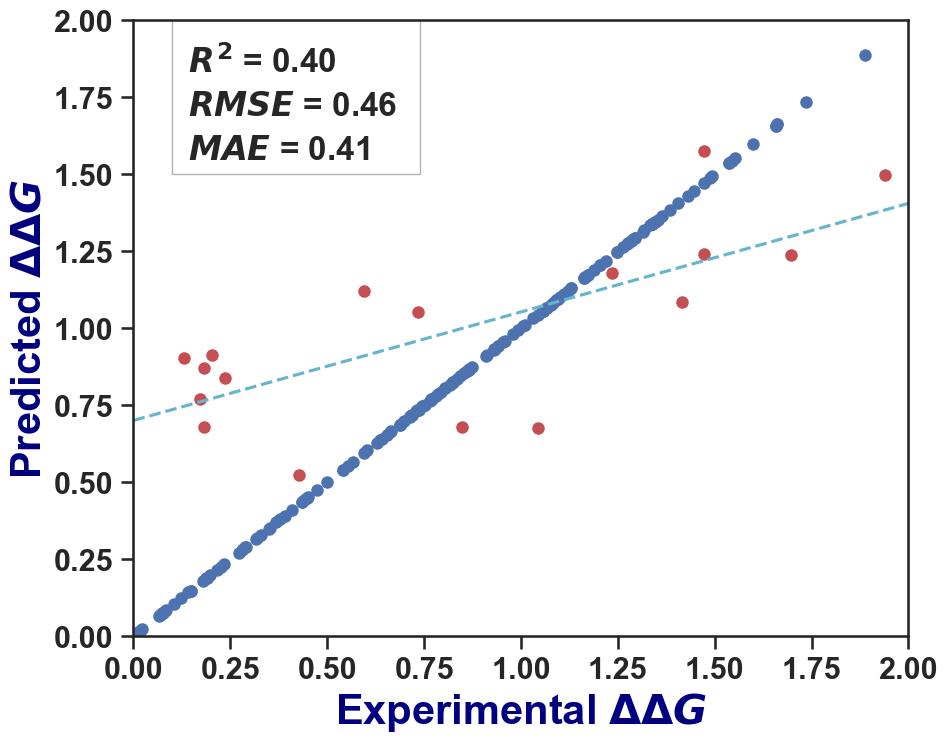

In [8]:
reg1 = xgboost.XGBRegressor(eta=0.083, colsample_bytree=0.93, subsample=0.89, max_depth=17)

test_type_id = [7, 8]
valid_type_id = [7]
filter_reaction = valid_type_id + test_type_id

train_ids = transfer_metadata[~transfer_metadata['ID'].isin(filter_reaction)]['idx'].index
valid_ids = transfer_metadata[transfer_metadata['ID'].isin(valid_type_id)]['idx'].index
train_set = dataset_morfeus_aug.loc[train_ids]
valid_set = dataset_morfeus_aug.loc[valid_ids]

X_train = train_set.iloc[:, :-1].values
y_train = train_set.iloc[:, -1].values
X_valid = valid_set.iloc[:, :-1].values
y_valid = valid_set.iloc[:, -1].values

train_conformers(reg1, X_train=X_train, X_test=X_valid, y_train=y_train, y_test=y_valid, n_conformers=N_CONFORMERS)

In [9]:
inter_des_dataset = pd.read_csv('data/calculators/descriptors/morfeus/raw_data_inter_chg1_xtb_intermediate.csv')
product_s_dataset = pd.read_csv('data/calculators/descriptors/morfeus/raw_data_product_s_xtb_product_s.csv')

product_base = 'Oc1ccc2ccccc2c1C1=C([*])CCc2ccccc21'
com_s_list = list(set(species_smiles[1]))
com_cat_list = list(set(species_smiles[2]))
transfer_dataset = []
inter_smi = []
com_cat_smi = []

com_s = 'O=C1c2ccccc2S(=O)(=O)N1Sc1ccccc1'

com_product = merge_products(product_base, com_s)
product_idx = get_mol_indices(com_product, mol_registry)[1][0]

product_conformer_data = product_s_dataset[
    product_s_dataset['index'] == product_idx
][:N_CONFORMERS].values[:, descriptor_start_idx:]

for com_cat in com_cat_list:
    if 'Se' in com_cat:
        continue

    com_inter = merge_intermediates(com_s, com_cat)
    inter_idx = get_mol_indices(com_inter, mol_registry)[1][0]
    try:
        intermediate_conformer_data = inter_des_dataset[
            inter_des_dataset['index'] == inter_idx
        ][:N_CONFORMERS].values[:, descriptor_start_idx:]
        if intermediate_conformer_data.shape[0] == 0:
            continue
    except IndexError:
        continue

    inter_smi.append(com_inter)
    com_cat_smi.append(com_cat)
    transfer_dataset.extend(
        list(chain(inter_des, product_des))
        for inter_des in intermediate_conformer_data
        for product_des in product_conformer_data
    )

transfer_dataset = scaler.transform(transfer_dataset)

D:\Anaconda\envs\python_3_11\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


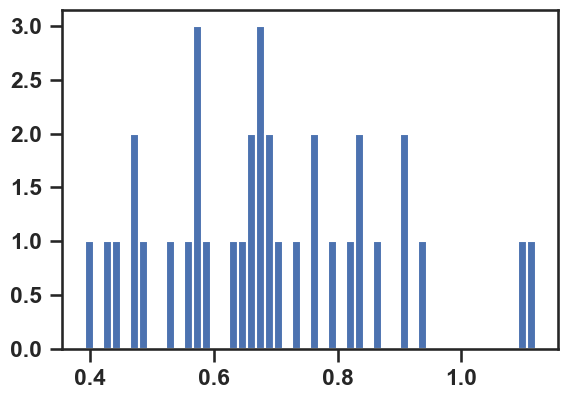

In [10]:
virtual_ddg = reg1.predict(transfer_dataset)

virtual_ddg_mean = np.array([np.mean(virtual_ddg[i:i+step]) for i in range(0, len(virtual_ddg), step)])
# virtual_ddg_mean = np.array([virtual_ddg[i] for i in range(0, len(virtual_ddg), step)])

top_sort = np.argsort(virtual_ddg_mean)[::-1]

plt.hist(virtual_ddg_mean, bins=50)
plt.show()

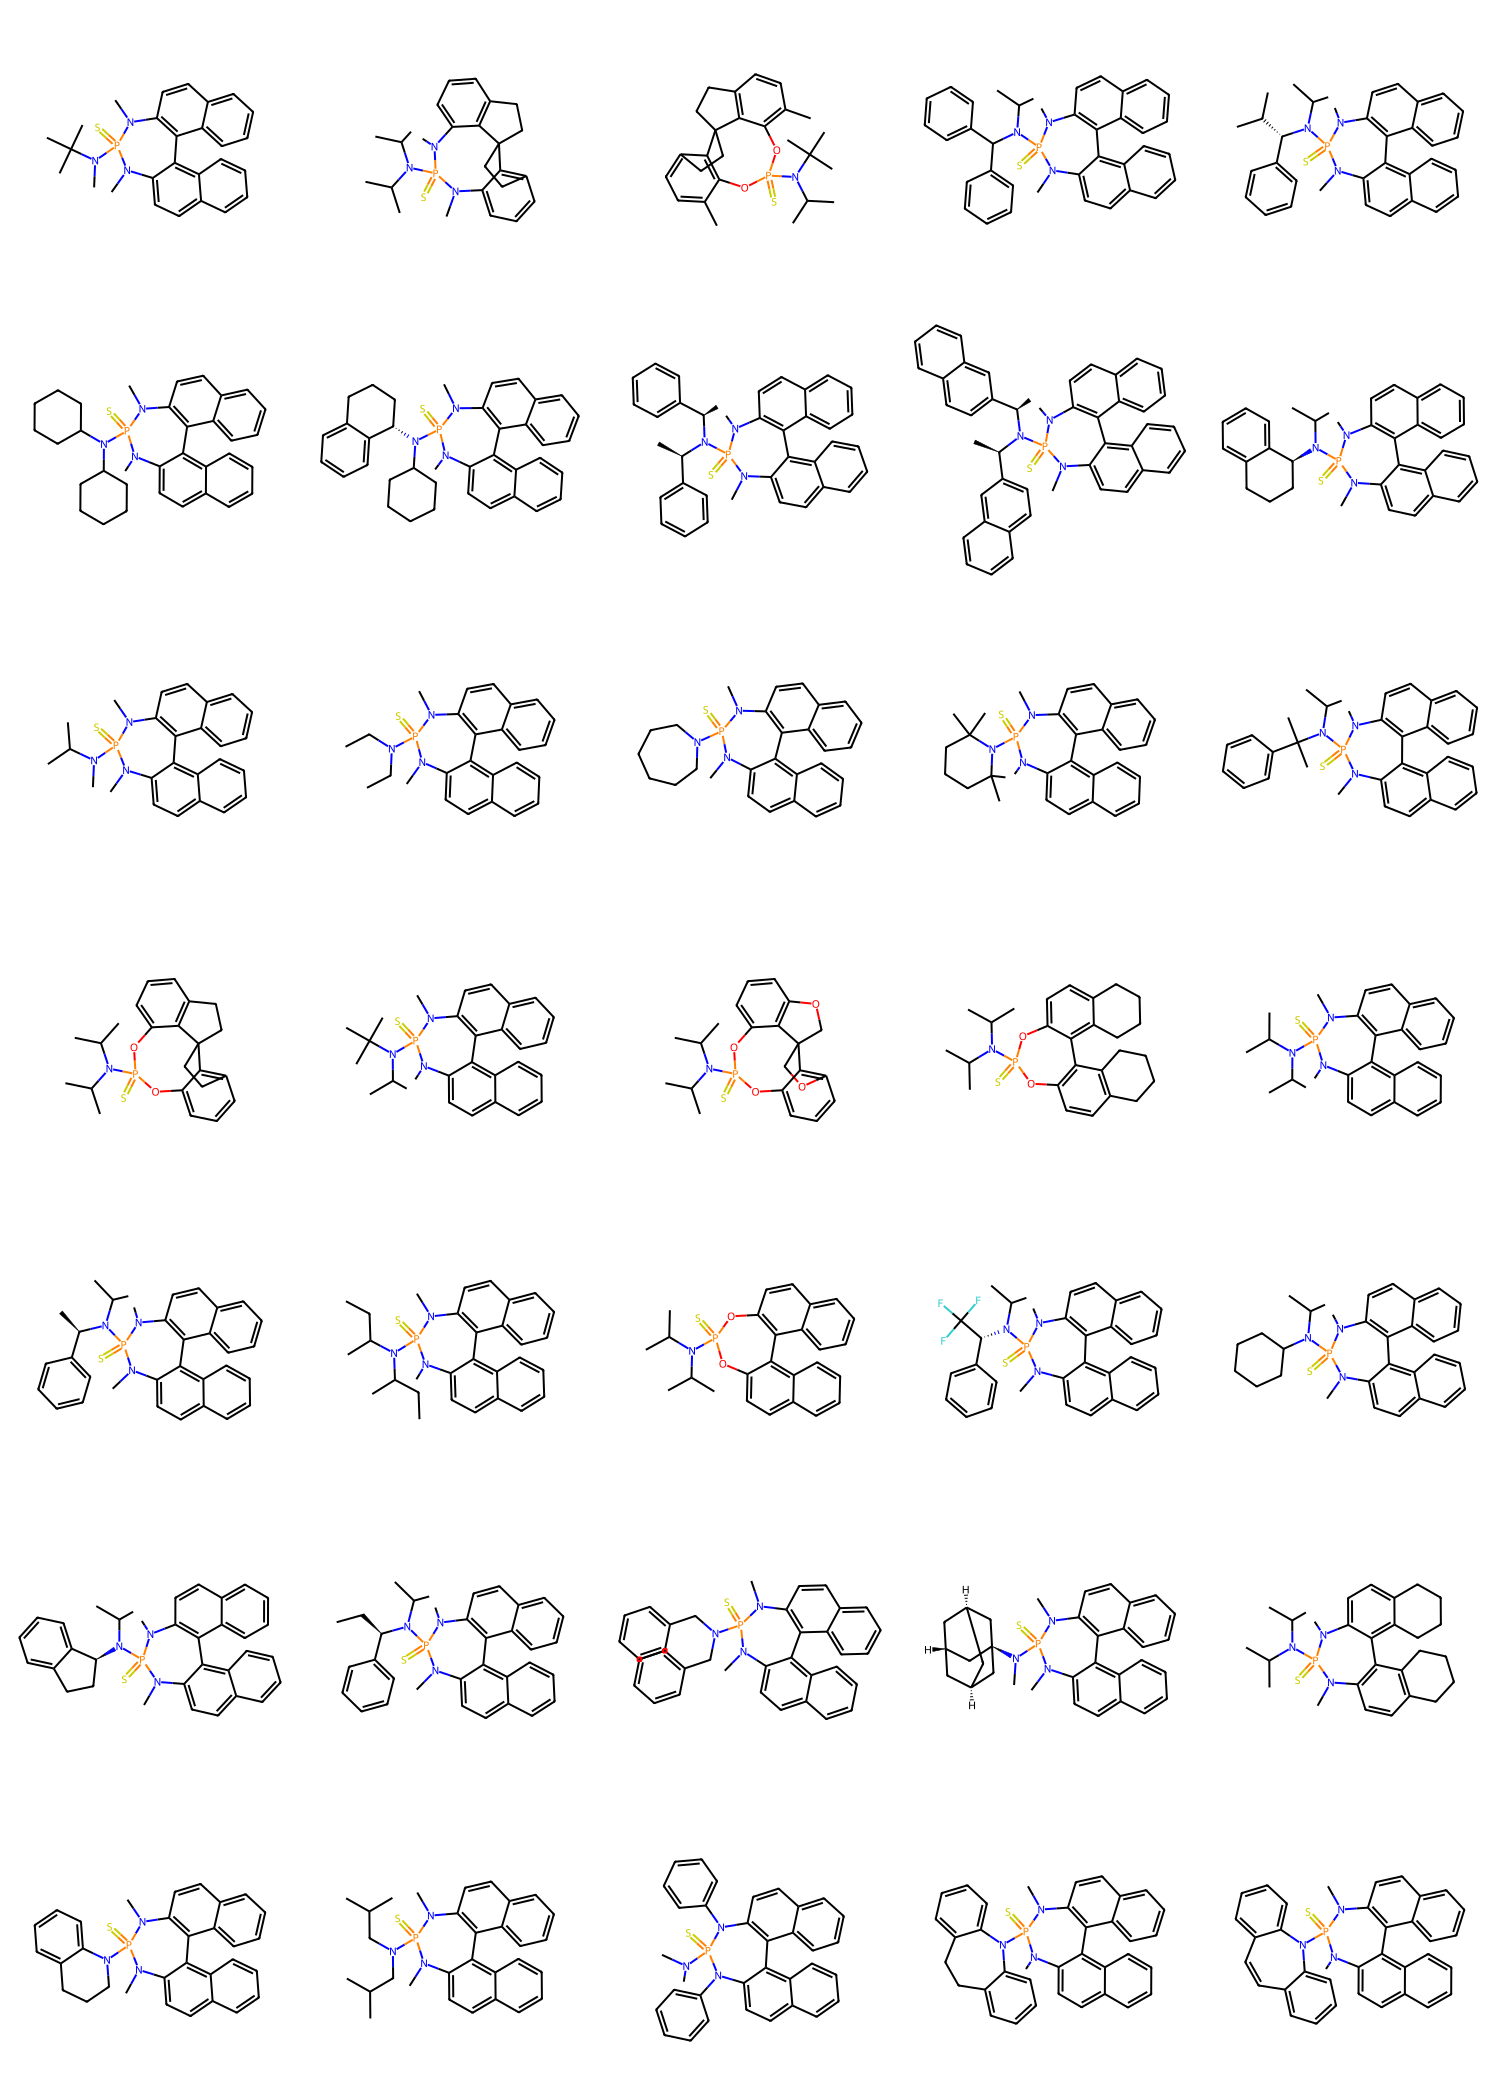

In [11]:
draw_smiles_list([com_cat_smi[i] for i in top_sort], None, maxMols=100)

# The second round of recommendation: Sulfenylating reagent

In [12]:
inter_des_dataset = pd.read_csv('data/calculators/descriptors/morfeus/raw_data_inter_chg1_xtb_intermediate.csv')
product_s_dataset = pd.read_csv('data/calculators/descriptors/morfeus/raw_data_product_s_xtb_product_s.csv')

transfer_dataset = []
inter_smi = []
com_s_smi = []

com_cat = 'CN1c2ccc3ccccc3c2-c2c(ccc3ccccc23)N(C)P1(=S)N(C)C(C)(C)C'

for com_s in com_s_list:    
    if 'Se' in com_s:
        continue

    com_inter = merge_intermediates(com_s, com_cat)
    inter_idx = get_mol_indices(com_inter, mol_registry)[1][0]

    com_product = merge_products(product_base, com_s)
    product_idx = get_mol_indices(com_product, mol_registry)[1][0]
    try:
        intermediate_conformer_data = inter_des_dataset[
            inter_des_dataset['index'] == inter_idx
        ][:N_CONFORMERS].values[:, descriptor_start_idx:]

        product_conformer_data = product_s_dataset[
            product_s_dataset['index'] == product_idx
        ][:N_CONFORMERS].values[:, descriptor_start_idx:]
        if intermediate_conformer_data.shape[0] == 0 or product_conformer_data.shape[0] == 0:
            continue
    except IndexError:
        continue

    inter_smi.append(com_inter)
    com_s_smi.append(com_s)
    transfer_dataset.extend(
        list(chain(inter_des, product_des))
        for inter_des in intermediate_conformer_data
        for product_des in product_conformer_data
    )

transfer_dataset = np.array(transfer_dataset)
transfer_dataset = scaler.transform(transfer_dataset)

D:\Anaconda\envs\python_3_11\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [13]:
reg2 = xgboost.XGBRegressor(eta=0.083, colsample_bytree=0.85, subsample=0.88, max_depth=10)

# Train residual model
stage_type_id = [1]
X_valid = dataset_morfeus_aug[transfer_metadata['ID'].isin(valid_type_id) & 
                         transfer_metadata['stage'].isin(stage_type_id)].iloc[:, :-1].values
y_valid = dataset_morfeus_aug[transfer_metadata['ID'].isin(valid_type_id) & 
                         transfer_metadata['stage'].isin(stage_type_id)].iloc[:, -1].values

y_valid_res = y_valid - reg1.predict(X_valid)
reg2.fit(X_valid, y_valid_res)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.083, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)

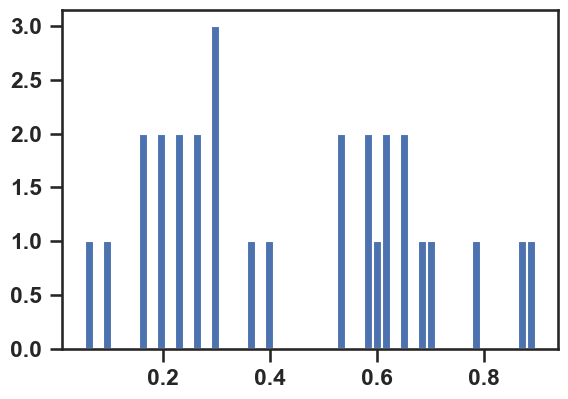

In [14]:
virtual_ddg = reg1.predict(transfer_dataset) + reg2.predict(transfer_dataset)

virtual_ddg_mean = np.array([max(0, np.mean(virtual_ddg[i:i+step])) 
                            for i in range(0, len(virtual_ddg), step)])

top_sort = np.argsort(virtual_ddg_mean)[::-1]

plt.hist(virtual_ddg_mean, bins=50)
plt.show()

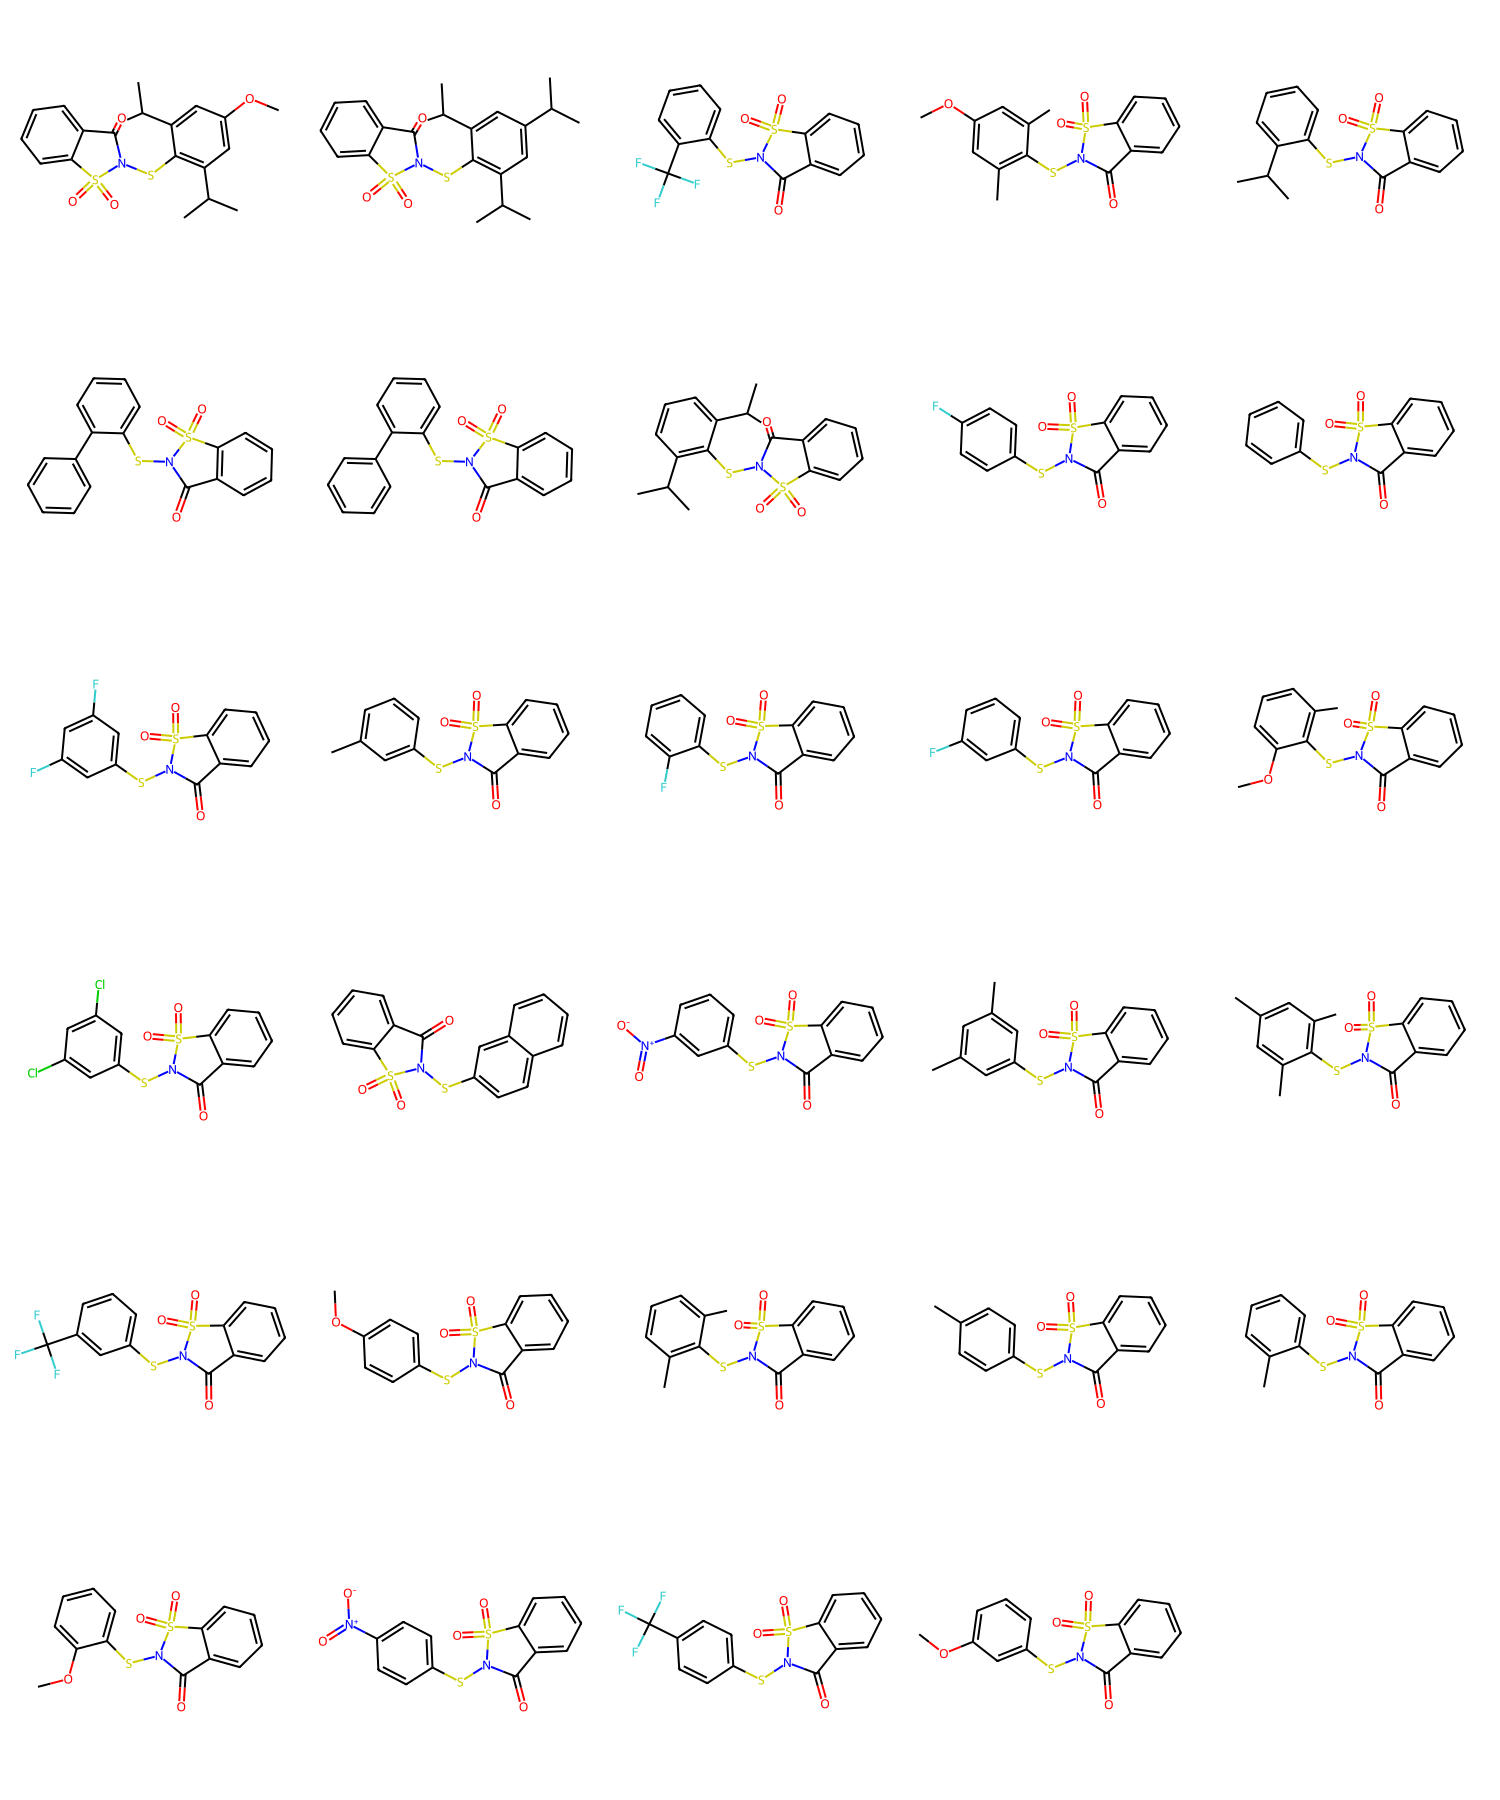

In [15]:
draw_smiles_list([com_s_smi[i] for i in top_sort], None, maxMols=100)

# Recommendation of disulfenylating reagent

In [16]:
com_ss_list = ['O=C1c2ccccc2S(=O)(=O)N1SSC(c1cccc(F)c1)=O',
 'Cc1cc(C)cc(C(SSN2C(=O)c3ccccc3S2(=O)=O)=O)c1',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccc(F)cc1)=O',
 'Cc1ccc(C(SSN2C(=O)c3ccccc3S2(=O)=O)=O)cc1',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccccc1-c1ccccc1)=O',
 'COc1cc(C)c(C(SSN2C(=O)c3ccccc3S2(=O)=O)=O)c(C)c1',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1cc(Cl)cc(Cl)c1)=O',
 'CC(C)c1cccc(C(C)C)c1C(SSN1C(=O)c2ccccc2S1(=O)=O)=O',
 'COc1cc(C(C)C)c(C(SSN2C(=O)c3ccccc3S2(=O)=O)=O)c(C(C)C)c1',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccccc1)=O',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccc2ccccc2c1)=O',
 'COc1cccc(C(SSN2C(=O)c3ccccc3S2(=O)=O)=O)c1',
 'CC(C)c1ccccc1C(SSN1C(=O)c2ccccc2S1(=O)=O)=O',
 'Cc1cc(C)c(C(SSN2C(=O)c3ccccc3S2(=O)=O)=O)c(C)c1',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1cccc([N+](=O)[O-])c1)=O',
 'COc1cccc(C)c1C(SSN1C(=O)c2ccccc2S1(=O)=O)=O',
 'Cc1ccccc1C(SSN1C(=O)c2ccccc2S1(=O)=O)=O',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccc([N+](=O)[O-])cc1)=O',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccccc1C(F)(F)F)=O',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1cc(F)cc(F)c1)=O',
 'Cc1cccc(C)c1C(SSN1C(=O)c2ccccc2S1(=O)=O)=O',
 'Cc1cccc(C(SSN2C(=O)c3ccccc3S2(=O)=O)=O)c1',
 'COc1ccccc1C(SSN1C(=O)c2ccccc2S1(=O)=O)=O',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccccc1F)=O',
 'CC(C)c1cc(C(C)C)c(C(SSN2C(=O)c3ccccc3S2(=O)=O)=O)c(C(C)C)c1',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1cccc(C(F)(F)F)c1)=O',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccccc1)=O',
 'COc1ccc(C(SSN2C(=O)c3ccccc3S2(=O)=O)=O)cc1',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccccc1-c1ccccc1)=O',
 'O=C1c2ccccc2S(=O)(=O)N1SSC(c1ccc(C(F)(F)F)cc1)=O']

com_ss_list = list(set(com_ss_list))

In [17]:
inter_des_dataset = pd.read_csv('data/calculators/descriptors/morfeus/raw_data_inter_chg1_xtb_ss.csv')
product_s_dataset = pd.read_csv('data/calculators/descriptors/morfeus/raw_data_product_ss_xtb_product_ss.csv')

product_base = 'Oc1ccc2ccccc2c1C1=C([*])CCc2ccccc21'

transfer_dataset = []
inter_smi = []
com_cat_smi = []

com_cat = 'CN1c2ccc3ccccc3c2-c2c(ccc3ccccc23)N(C)P1(=S)N(C)C(C)(C)C'

for com_s in com_ss_list:    
    if 'Se' in com_s:
        continue

    com_inter = merge_intermediates(com_s, com_cat)
    inter_idx = get_mol_indices(com_inter, mol_registry)[1][0]

    com_product = merge_products(product_base, com_s)
    product_idx = get_mol_indices(com_product, mol_registry)[1][0]
    try:
        intermediate_conformer_data = inter_des_dataset[
            inter_des_dataset['index'] == inter_idx
        ][:N_CONFORMERS].values[:, descriptor_start_idx:]
        product_conformer_data = product_s_dataset[
            product_s_dataset['index'] == product_idx
        ][:N_CONFORMERS].values[:, descriptor_start_idx:]
        if intermediate_conformer_data.shape[0] == 0 or product_conformer_data.shape[0] == 0:
            continue
    except IndexError:
        continue

    inter_smi.append(com_inter)
    com_s_smi.append(com_s)
    transfer_dataset.extend(
        list(chain(inter_des, product_des))
        for inter_des in intermediate_conformer_data
        for product_des in product_conformer_data
    )

transfer_dataset = scaler.transform(transfer_dataset)

D:\Anaconda\envs\python_3_11\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


C:\Users\Greenire\AppData\Local\Temp\ipykernel_3248\2502431448.py:197: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(y_test, y_pred_test, deg=1)
D:\Anaconda\envs\python_3_11\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Anaconda\envs\python_3_11\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


(nan, 0.9999996127188114)

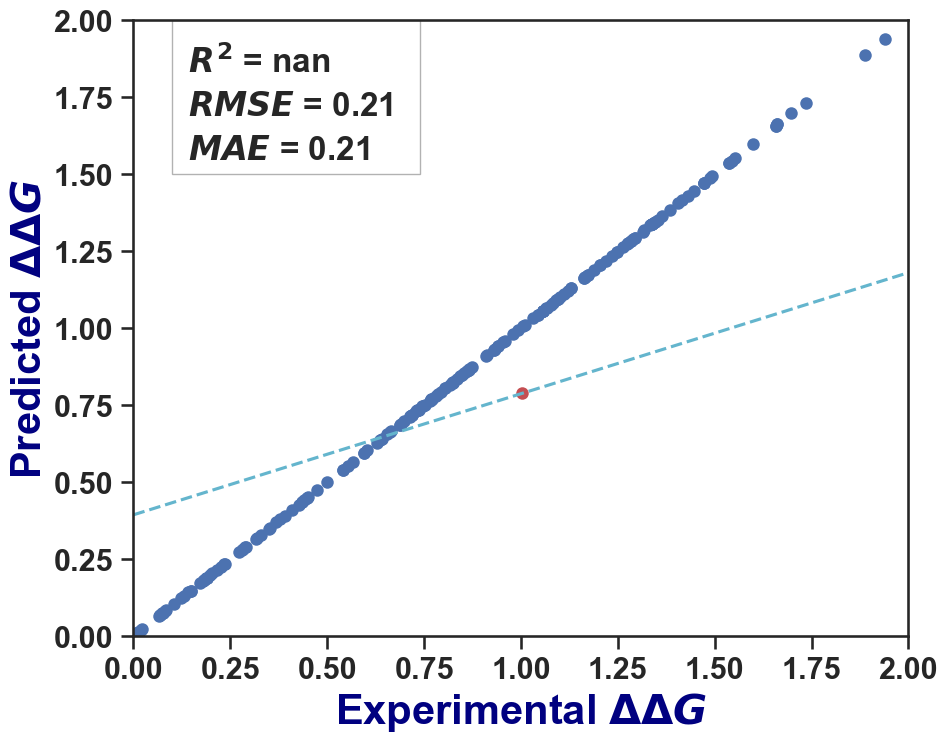

In [18]:
test_type_id = [8]
valid_type_id = [8]
filter_reaction = valid_type_id + test_type_id

train_ids = transfer_metadata[~transfer_metadata['ID'].isin(filter_reaction)]['idx'].index
valid_ids = transfer_metadata[transfer_metadata['ID'].isin(valid_type_id)]['idx'].index
train_set = dataset_morfeus_aug.loc[train_ids]
valid_set = dataset_morfeus_aug.loc[valid_ids]

X_train = train_set.iloc[:, :-1].values
y_train = train_set.iloc[:, -1].values
X_valid = valid_set.iloc[:, :-1].values
y_valid = valid_set.iloc[:, -1].values

train_conformers(reg1, X_train=X_train, X_test=X_valid, y_train=y_train, y_test=y_valid, n_conformers=N_CONFORMERS)

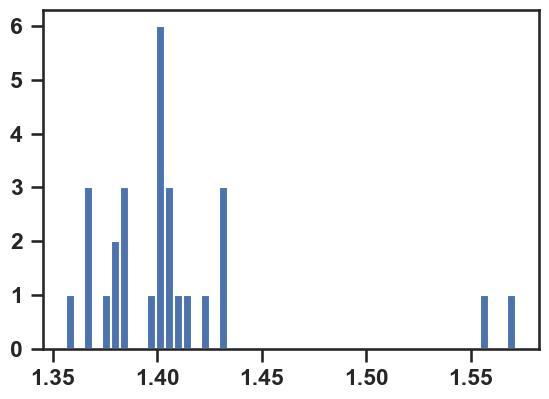

In [19]:
virtual_ddg = reg1.predict(transfer_dataset)

virtual_ddg_mean = np.array([np.mean(virtual_ddg[i:i+step]) for i in range(0, len(virtual_ddg), step)])

top_sort = np.argsort(virtual_ddg_mean)[::-1]

plt.hist(virtual_ddg_mean, bins=50)
plt.show()

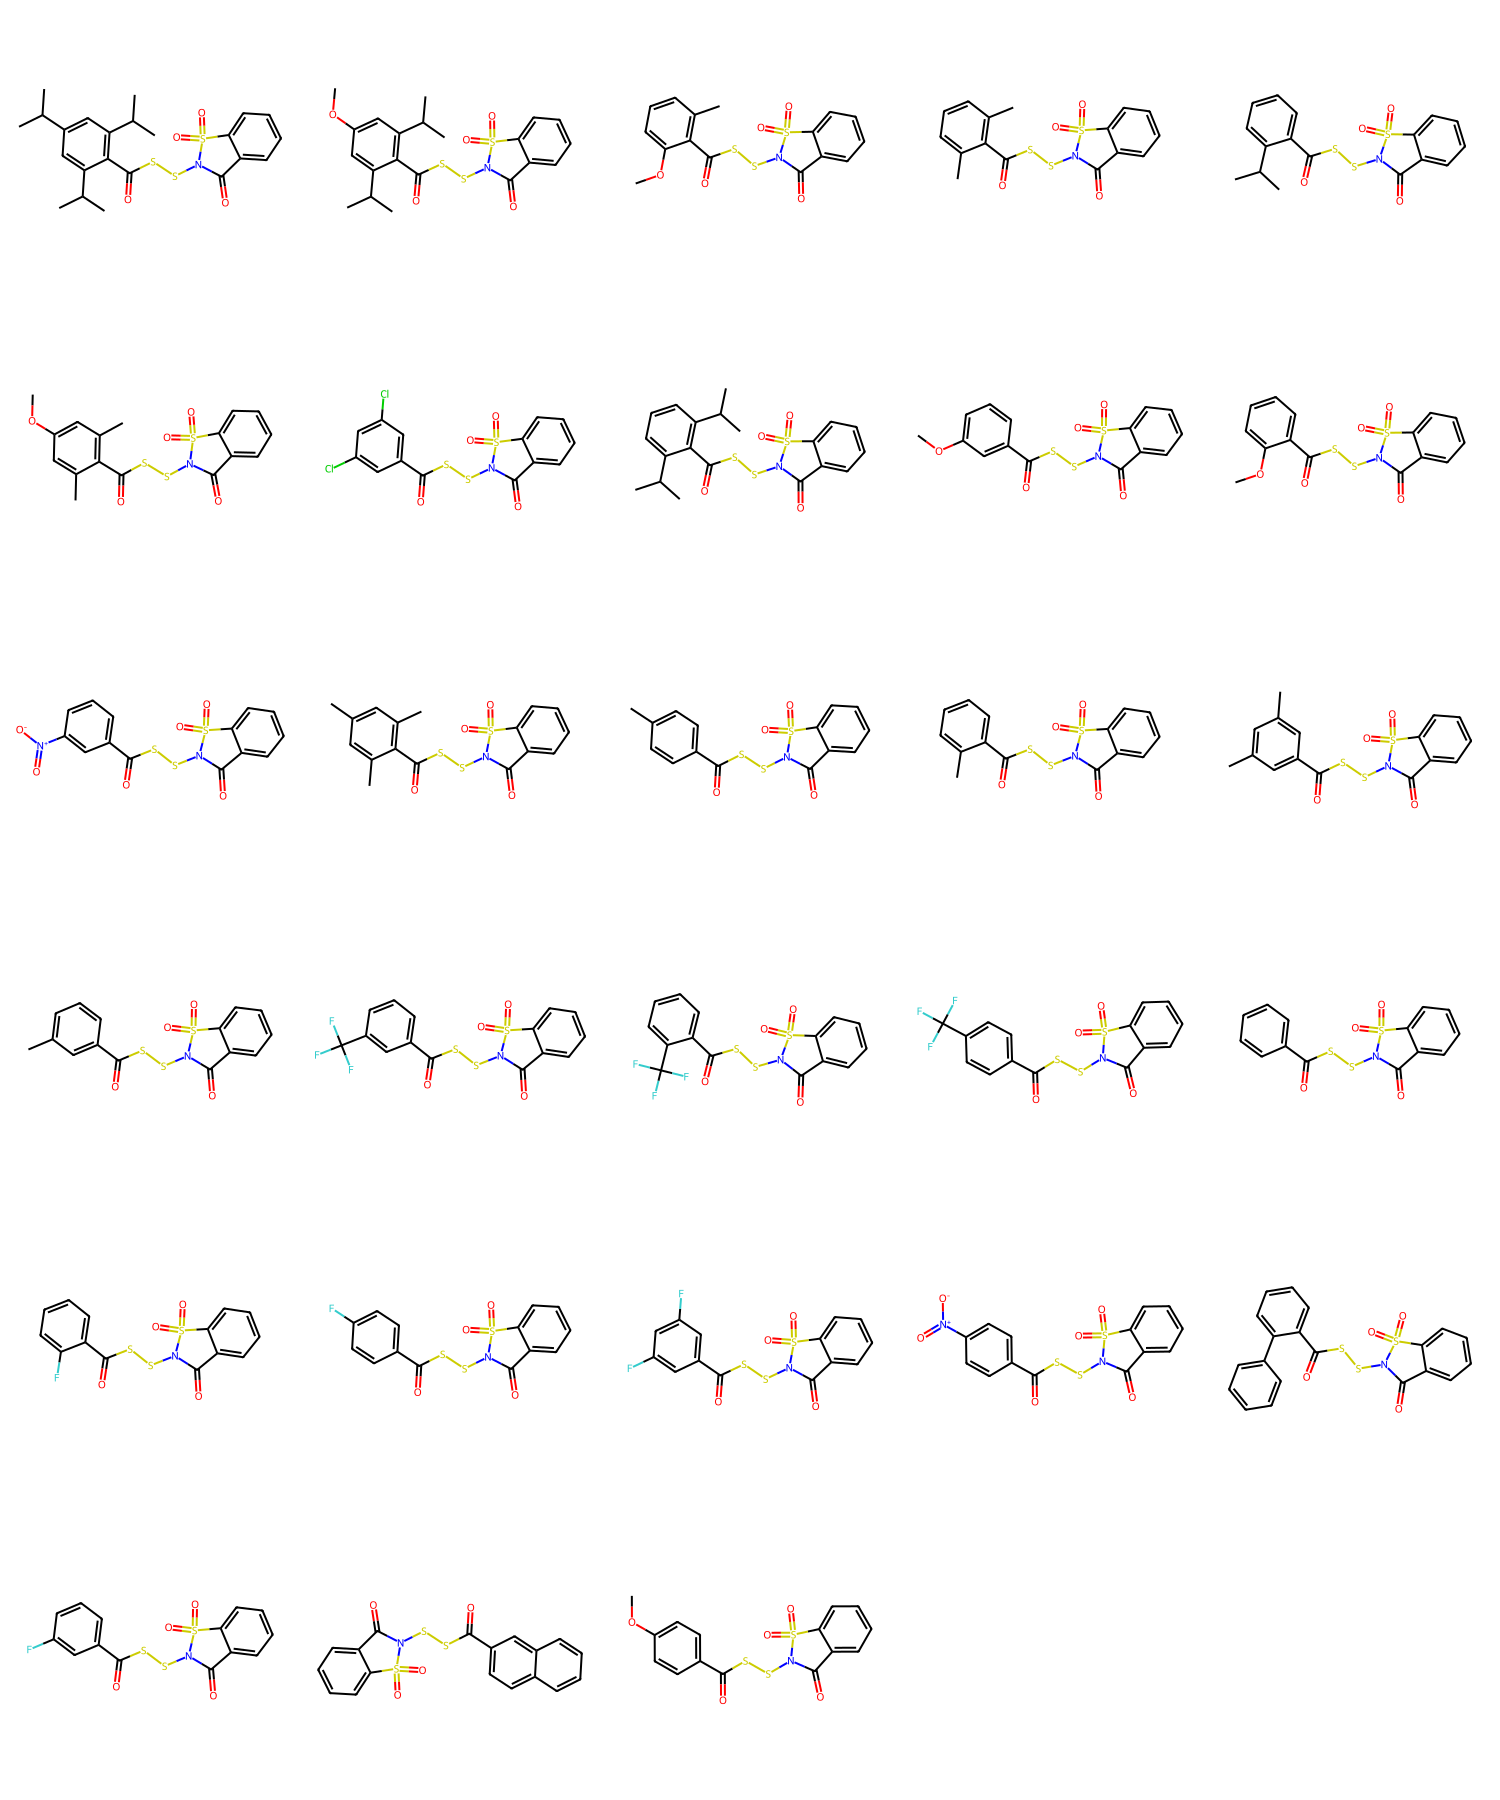

In [20]:
draw_smiles_list([com_ss_list[i] for i in top_sort], None)